In [4]:
# work environment: jl2815
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from skgstat import variogram
import numpy as np
from typing import Callable   # nearest neighbor function input type
import sklearn.neighbors  # nearest neighbor
from sklearn.neighbors import BallTree # for space_center function
import sys 
#  sys.path

from GEMS_TCO import orbitmap
from GEMS_TCO.smoothspace import space_average

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormap module  # Create a colormap (e.g., 'viridis' or 'plasma')
import pickle

## Setup

Initiate ```gems_tco``` package, set coarse coordinates and then create a hash map ```coarse_dicts``` that maps timestamps to dataframe.

In [ ]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\data_24_07_0131_N510_E110120.csv")
instance = orbitmap.MakeOrbitdata(df, 5,10,110,120)

# Load the dictionary from the pickle file
filepath = "C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\sparse_cen_map24_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y24m01day01_hm02:12']

rho_lat = 1
rho_lon = 1
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

print(len(lat_n))
print(len(lon_n))

Create the hash map ```coarse_dicts```, where the keys represent a combination of the year,month,day and hour and the values are filtered ```DataFrame```.

In [ ]:
coarse_dicts = {}

years = ['2023','2024']
for year in years:
    for month in range(1, 13):  # Iterate over all months
        filepath = f"C:\\Users\\joonw\\TCO\\data_engineering\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

        print(f"Finished processing {year} {month}.")

In [17]:
df_list = []

for key in coarse_dicts:
    df_list.append(coarse_dicts[key])

df_entire = pd.concat(df_list, axis=0, ignore_index=True)

We need to remove some outliers. 

In [34]:
print(df_entire.shape)
cur = df_entire.copy()
mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
cur = cur[~mask]
var_value = np.var(cur['ColumnAmountO3'])
cur.loc[mask, 'ColumnAmountO3'] = var_value

print(cur.shape)

(100780000, 5)
(100772598, 5)


In [ ]:
coarse_dict = {}
for key in coarse_dicts:
    cur = coarse_dicts[key]
    mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
    print(f'{key} {len(mask)}')
    cur = cur[~mask]
    var_value = np.var(cur['ColumnAmountO3'])
    cur.loc[mask, 'ColumnAmountO3'] = var_value
    coarse_dict[key] = cur

# Conclusion

## Timeseries plots var, variance, semivariograms.

We can clearly observe some short and long term cycles. Therefore, if I want to fit the data using deep learning models, we should consider ```LSTM``` rather than ```RNN``` to capture long term behaviors.

I considered using ```CNN``` to capture spatial dependence structure, followed by applying ```LSTM``` to capture temporal dependence structure. 

However, after extensive experiments, it seems ```CNN``` is not suited for capturing high resolution spatial information. Therefore, I suggest using ```Gaussian Process models``` to capture high resolution spatial information and then use ```LSTM``` to capture temporal information.

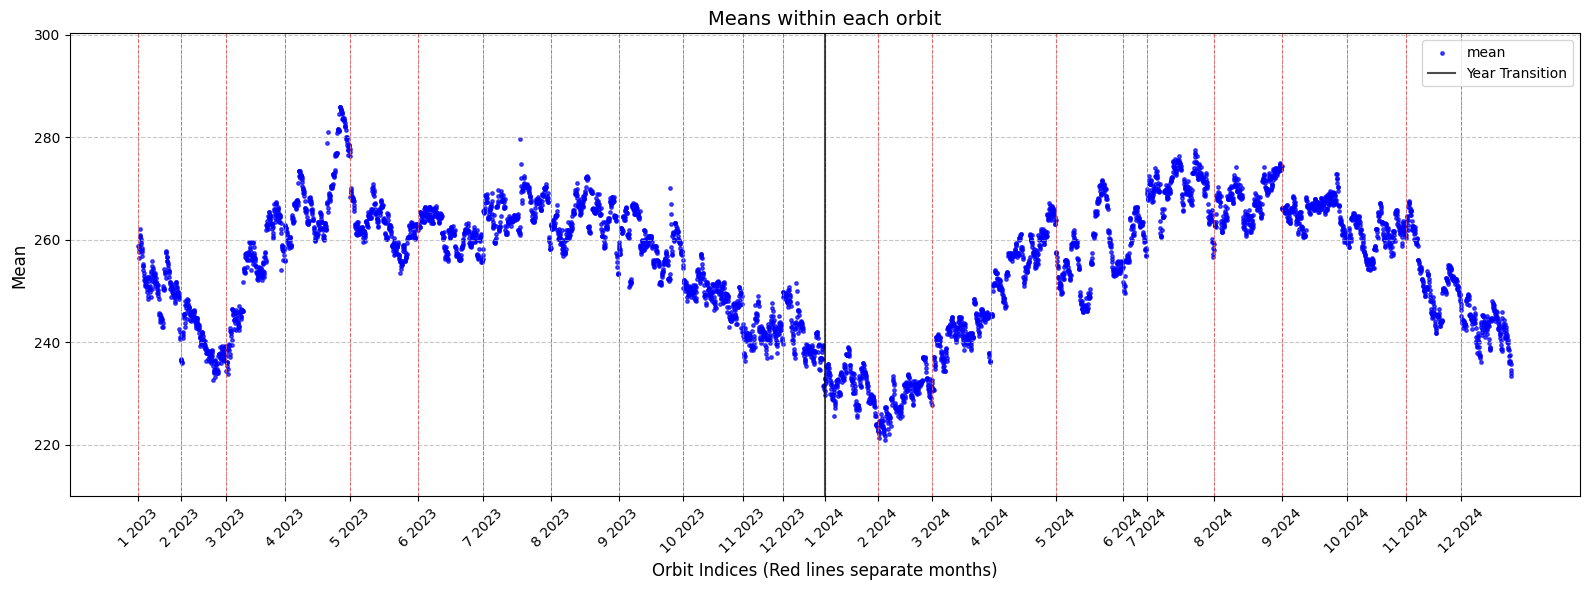

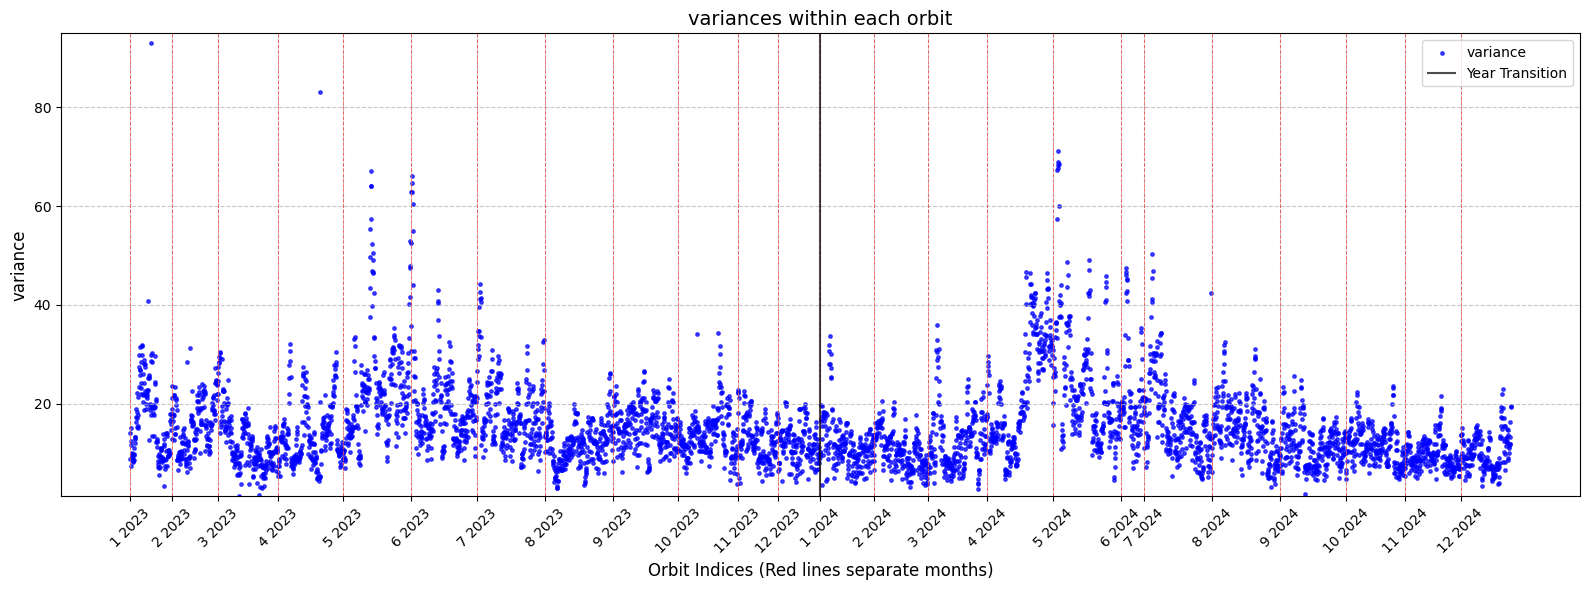

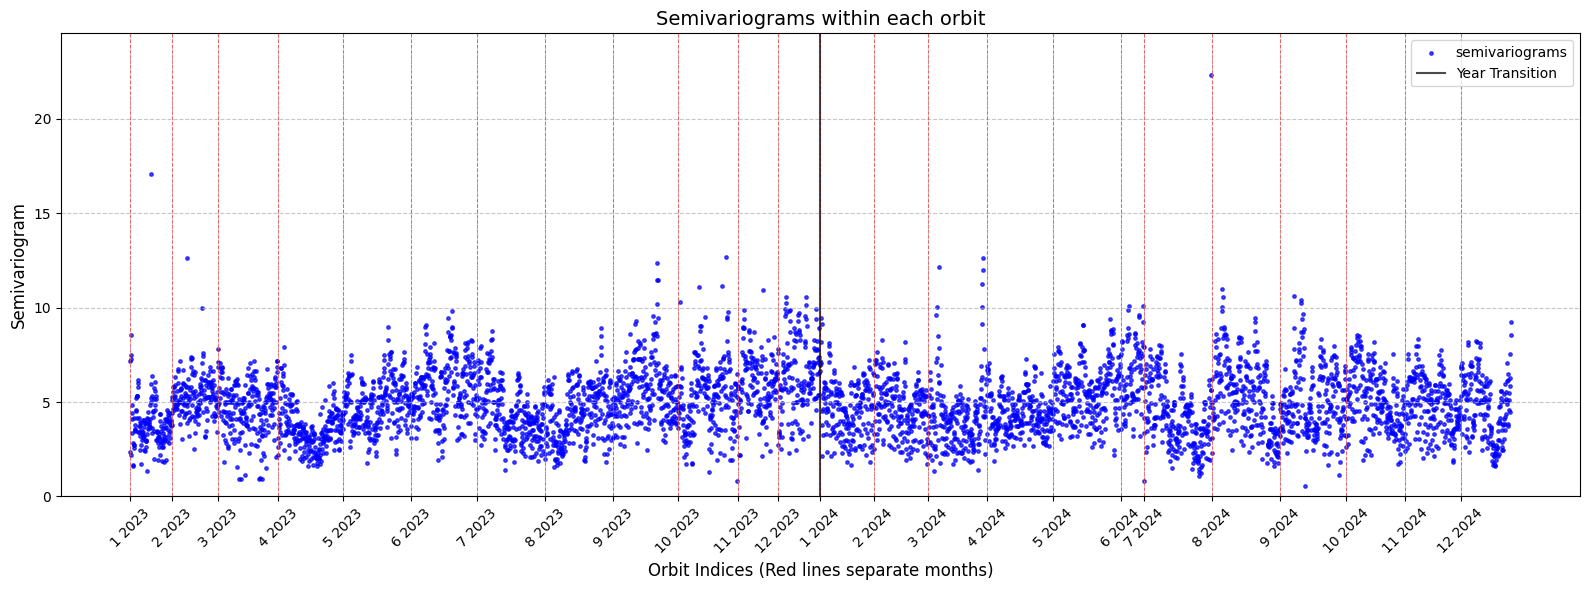

In [106]:
# Plot
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, mean_timeseries, marker='o', s=6, color='b', alpha=0.7, label='mean')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(mean_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.title('Means within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(mean_timeseries)*0.95, max(mean_timeseries) * 1.05])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, var_timeseries, marker='o', s=6, color='b', alpha=0.7, label='variance')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(var_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('variance', fontsize=12)
plt.title('variances within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([ min(var_timeseries) * 0.97, max(var_timeseries) * 1.02])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# Plot run 456 minute
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, sem_timeseries, marker='o', s=6, color='b', alpha=0.7, label='semivariograms')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(var_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Semivariogram', fontsize=12)
plt.title('Semivariograms within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([0, max(sem_timeseries) * 1.1])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# Reference codes

Means

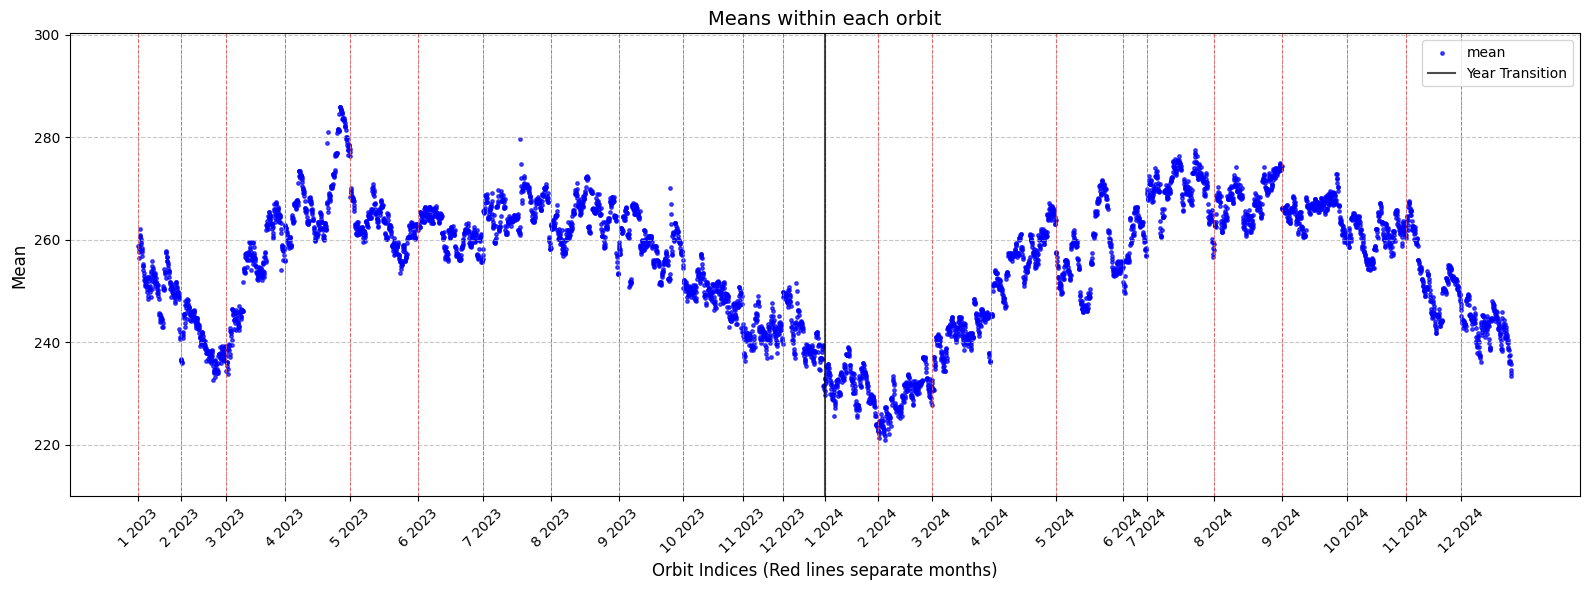

In [98]:
mean_timeseries = []
month_positions = [0]
m_labels = ['1']
prev_month = '01'
year_transition = None

# Generate meaniance and month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    mean_timeseries.append(np.mean(cur['ColumnAmountO3']))
    current_month = key[5:7]
    if current_month != prev_month:
        month_positions.append(idx)
        m_labels.append(f"{int(current_month)}")  # Month numbers
        prev_month = current_month
    if key[:4] == '2024' and year_transition is None:
        year_transition = idx  # Track year change

# Generate orbit indices
orbit_indices = range(len(mean_timeseries))

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, mean_timeseries, marker='o', s=6, color='b', alpha=0.7, label='mean')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(mean_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.title('Means within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(mean_timeseries)*0.95, max(mean_timeseries) * 1.05])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

Variances

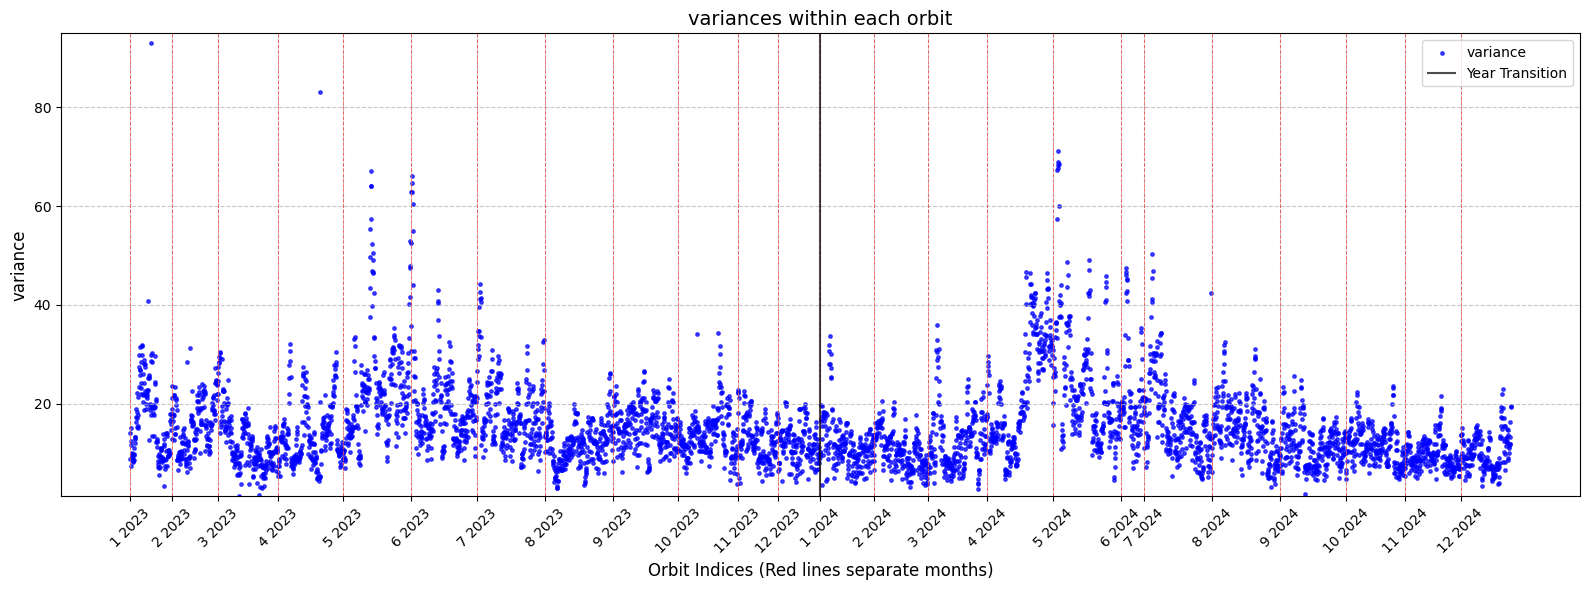

In [107]:
var_timeseries = []
month_positions = [0]
m_labels = ['1']
prev_month = '01'
year_transition = None

# Generate variance and month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    var_timeseries.append(np.var(cur['ColumnAmountO3']))
    current_month = key[5:7]
    if current_month != prev_month:
        month_positions.append(idx)
        m_labels.append(f"{int(current_month)}")  # Month numbers
        prev_month = current_month
    if key[:4] == '2024' and year_transition is None:
        year_transition = idx  # Track year change

# Generate orbit indices
orbit_indices = range(len(var_timeseries))

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, var_timeseries, marker='o', s=6, color='b', alpha=0.7, label='variance')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(var_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('variance', fontsize=12)
plt.title('variances within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([ min(var_timeseries) * 0.97, max(var_timeseries) * 1.02])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

Semivariograms

In [ ]:
sem_timeseries = []
month_positions = [0]
m_labels = ['1']
prev_month = '01'
year_transition = None

sem_lag = 0.2
tolerance = 0.02

# Generate variance and month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    coordinates = np.array(cur[['Latitude', 'Longitude']])
    values = np.array(cur['ColumnAmountO3'])
    pairwise_distances = squareform(pdist(coordinates))
    valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                            (pairwise_distances <= sem_lag + tolerance))

    if len(valid_pairs[0]) == 0:
        sem_timeseries.append(np.nan)
        continue

    semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

    sem_timeseries.append(semivariances)
    current_month = key[5:7]
    if current_month != prev_month:
        month_positions.append(idx)
        m_labels.append(f"{int(current_month)}")  # Month numbers
        prev_month = current_month
    if key[:4] == '2024' and year_transition is None:
        year_transition = idx  # Track year change

# Generate orbit indices
orbit_indices = range(len(sem_timeseries))

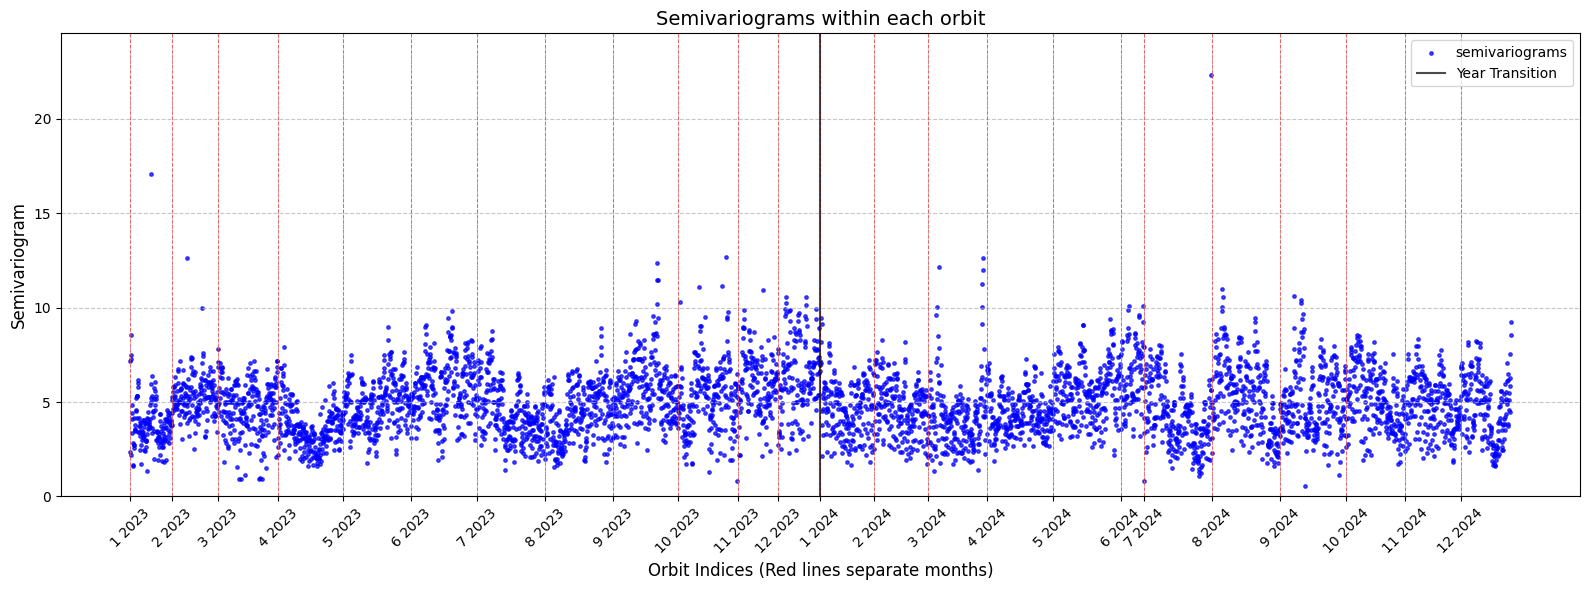

In [95]:
# Plot run 456 minute
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, sem_timeseries, marker='o', s=6, color='b', alpha=0.7, label='semivariograms')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(var_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Semivariogram', fontsize=12)
plt.title('Semivariograms within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([0, max(sem_timeseries) * 1.1])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()
